# Определение возраста покупателей

**Описание проекта**

Сетевой супермаркет внедряет систему компьютерного зрения для обработки фотографий покупателей. Фотофиксация в прикассовой зоне поможет определять возраст клиентов, чтобы:  

- Анализировать покупки и предлагать товары, которые могут заинтересовать покупателей этой возрастной группы;
- Контролировать добросовестность кассиров при продаже алкоголя.  

Необходимо построить модель, которая по фотографии определит приблизительный возраст человека. Для обучения модели предоставлен набор фотографий людей с указанием возраста. Предельное значение MAE: 8.

## Исследовательский анализ данных

In [1]:
# импорт библиотек
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
from tensorflow.keras.preprocessing.image import ImageDataGenerator

Получим размер выборки.

In [2]:
# загрузка датасета
labels = pd.read_csv('labels.csv')
datagen = ImageDataGenerator(rescale=1./255)
gen_flow = datagen.flow_from_dataframe(
        dataframe=labels,
        directory='final_files/',
        x_col='file_name',
        y_col='real_age',
        target_size=(224, 224),
        batch_size=32,
        class_mode='raw',
        seed=12345)

Found 7591 validated image filenames.


Рассмотрим распределение возраста в имеющейся выборке.

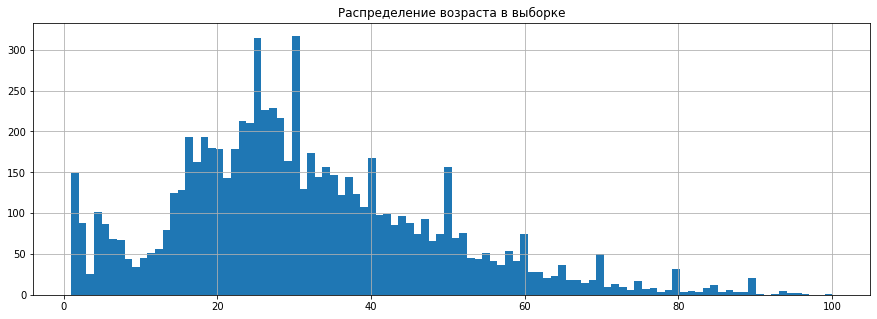

In [3]:
labels['real_age'].hist(bins=100, figsize=(15, 5), grid=True)
plt.title('Распределение возраста в выборке')
plt.show()

Распределение возраста в целом напоминает нормальное распределение. Однако присутствует всплеск значений в диапазоне 1-2 лет и 5-10 лет. Чем выше возраст, тем меньше изображений представлено в выборке, что коррелирует с естественным циклом жизни человека.

Выведем на экран первые 15 изображений датасета.

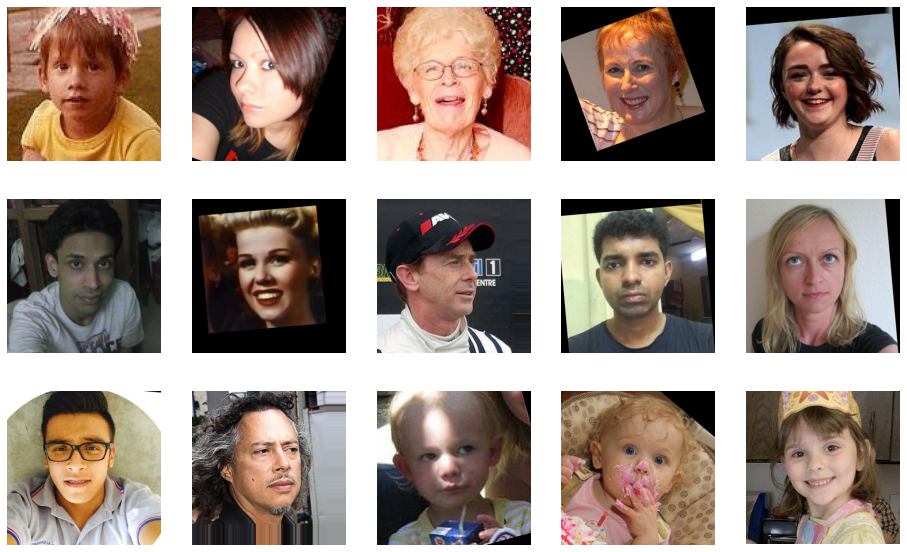

In [4]:
fig = plt.figure(figsize=(16, 10))
for i in range(0, 15):
    image = Image.open('final_files/' + labels.loc[i, 'file_name'])
    array = np.array(image)
    fig.add_subplot(3, 5, i+1)
    plt.imshow(array)
    plt.axis('off')
plt.show()

В выборке представлены изображения разного качества (с рамками, размытием), также представлены различные эмоции и повороты головы. Это хорошо для обучения модели, можно попробовоть добиться требуемого уровня среднего абсолютного отклонения без добавления аугментаций.

## Обучение модели

Код обучения модели:

```python
import os
import pandas as pd
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.resnet import ResNet50

def load_train(path):
    df_labels = pd.read_csv(os.path.join(path, 'labels.csv'))
    train_datagen = ImageDataGenerator(rescale=1./255,  
                                       validation_split=0.25,
                                       vertical_flip=True,
                                       horizontal_flip=True)
    train_data = train_datagen.flow_from_dataframe(
        df_labels,
        x_col='file_name', 
        y_col='real_age',
        directory=os.path.join(path, 'final_files/'), 
        target_size=(224, 224), 
        batch_size=16,  
        class_mode='raw', 
        subset='training', 
        seed=12345)
    return train_data

def load_test(path):
    df_labels = pd.read_csv(os.path.join(path, 'labels.csv'))
    test_datagen = ImageDataGenerator(rescale=1./255,  validation_split=0.25)
    test_data = test_datagen.flow_from_dataframe(
        df_labels,
        x_col='file_name', 
        y_col='real_age',
        directory=os.path.join(path, 'final_files/'), 
        target_size=(224, 224), 
        batch_size=16,  
        class_mode='raw', 
        subset='validation',
        seed=12345)
    return test_data

def create_model(input_shape):
    optimizer = Adam(lr=0.0001)
    backbone = ResNet50(input_shape=input_shape,
                        weights='imagenet', 
                        include_top=False)
    model = Sequential()
    model.add(backbone)
    model.add(GlobalAveragePooling2D())
    model.add(Dense(1, activation='relu'))
    model.compile(optimizer=optimizer, loss='mean_squared_error', 
                  metrics=['mean_absolute_error'])
    return model

def train_model(model, train_data, test_data, batch_size=None, epochs=5,
                steps_per_epoch=None, validation_steps=None):

    model.fit(train_data,
              validation_data=test_data,
              batch_size=batch_size, epochs=epochs,
              steps_per_epoch=steps_per_epoch,
              validation_steps=validation_steps,
              verbose=2, shuffle=True)

    return model
```

Результат обучения модели:

```
Found 5694 validated image filenames.  
Found 1897 validated image filenames.

Downloading data from https://github.com/keras-team/keras-applications/releases/download/resnet/resnet50_weights_tf_dim_ordering_tf_kernels_notop.h5

<class 'tensorflow.python.keras.engine.sequential.Sequential'>

Train for 356 steps, validate for 119 steps
Epoch 1/5
356/356 - 71s - loss: 234.3179 - mean_absolute_error: 11.2782 - val_loss: 854.6843 - val_mean_absolute_error: 24.1895
Epoch 2/5
356/356 - 39s - loss: 111.7088 - mean_absolute_error: 8.0588 - val_loss: 148.7040 - val_mean_absolute_error: 9.3673
Epoch 3/5
356/356 - 39s - loss: 88.1577 - mean_absolute_error: 7.1594 - val_loss: 95.5419 - val_mean_absolute_error: 7.3006
Epoch 4/5
356/356 - 38s - loss: 74.7589 - mean_absolute_error: 6.5905 - val_loss: 101.6360 - val_mean_absolute_error: 7.6104
Epoch 5/5
356/356 - 38s - loss: 61.3485 - mean_absolute_error: 5.9775 - val_loss: 103.2792 - val_mean_absolute_error: 7.6084

119/119 - 9s - loss: 103.2792 - mean_absolute_error: 7.6084
Test MAE: 7.6084
```

Уже на третьей эпохе удалось достичь значения MAE на тестовой выборке менее 8.

## Анализ обученной модели

Для обучения модели была использована предобученная на ImageNet архитектура ResNet50 без головы и без заморозки.
Параметры обучения:
- оптимизатор Adam с learning rate = 0.0001
- размер батча = 16
- количество эпох = 5

В качестве функции потерь использована MSE, в качестве метрики - MAE.

Достигнутое значение MAE на тестовой выборке 7.6.

После третьей эпохи наблюдается незначительное переробучение: MAE продолжает снижаться на обучающей выборке и практически не меняется на тестовой.

Полученная модель дает хороший результат при определении возраста по фотографии, особенно учитывая тот факт, что на фотографии могут быть не различимы некоторые признаки возрастных изменений.

Данную модель можно использовать с целью рекомендаций товаров покупателям, т.к. разница в несколько лет не сильно сказывается на потребительской корзине.

Однако модель не подходит для контроля кассиров при продаже алкоголя, т.к. в данном вопросе разница в несколько лет становится существенной.